In [1]:
# Reading Google drive 

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Importing modules

# lstm model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.utils import to_categorical
from matplotlib import pyplot
from keras.models import load_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

In [0]:
# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values

In [0]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded

In [0]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

In [0]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', prefix + '/content/drive/My Drive/Colab Notebooks/LAR/data/')
	print(trainX.shape, trainy.shape)
	# load all test
	testX, testy = load_dataset_group('test', prefix + '/content/drive/My Drive/Colab Notebooks/LAR/data/')
	print(testX.shape, testy.shape)
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	print(trainX.shape, trainy.shape, testX.shape, testy.shape)
	return trainX, trainy, testX, testy

In [0]:
# fit and evaluate a model
def evaluate_RNN_model(trainX, trainy, testX, testy):
	verbose, epochs, batch_size = 0, 15, 64
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	model = Sequential()
	model.add(SimpleRNN(units=100, input_shape=(trainX.shape[1], 
    trainX.shape[2])))
	model.add(Dropout(0.5))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return accuracy, model

In [0]:
# fit and evaluate a model
def evaluate_LSTM_model(trainX, trainy, testX, testy):
	verbose, epochs, batch_size = 0, 15, 64
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	model = Sequential()
	model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
	model.add(Dropout(0.5))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network
  
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
  #model.save('/content/drive/My Drive/Colab Notebooks/LAR/LSTM.hdf5')
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return accuracy, model

In [0]:
# summarize scores
#def summarize_results(scores):

#print(scores)
#	m, s = mean(scores), std(scores)
#	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
  


In [0]:
# run LSTM  experiment
def run_RNN_experiment(repeats=10):
	# load data
	trainX, trainy, testX, testy = load_dataset()
	# repeat experiment
	scores = list()
	for r in range(repeats):
		score,model = evaluate_RNN_model(trainX, trainy, testX, testy)
		score = score * 100.0
		print('RNN Model Score: >%d: %.3f' % (r+1, score))
		scores.append(score)
    
	return model

In [0]:
# run LSTM  experiment
def run_LSTM_experiment(repeats=10):
	# load data
	trainX, trainy, testX, testy = load_dataset()
	# repeat experiment
	scores = list()
	for r in range(repeats):
		score,model = evaluate_LSTM_model(trainX, trainy, testX, testy)
		score = score * 100.0
		print('LSTM Model Score: >%d: %.3f' % (r+1, score))
		scores.append(score)
    
	return model

In [0]:
RNN_model = run_RNN_experiment()

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
RNN Model Score: >1: 67.933
RNN Model Score: >2: 69.766
RNN Model Score: >3: 84.153
RNN Model Score: >4: 85.137
RNN Model Score: >5: 57.448
RNN Model Score: >6: 62.776
RNN Model Score: >7: 85.103
RNN Model Score: >8: 61.486
RNN Model Score: >9: 70.139
RNN Model Score: >10: 45.945


In [0]:
RNN_model.save('/content/drive/My Drive/Colab Notebooks/LAR/RNN.hdf5')
RNN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_11 (SimpleRNN)    (None, 100)               11000     
_________________________________________________________________
dropout_14 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_28 (Dense)             (None, 6)                 606       
Total params: 21,706
Trainable params: 21,706
Non-trainable params: 0
_________________________________________________________________


In [0]:
LSTM_model = run_LSTM_experiment()

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
LSTM Model Score: >1: 89.481
LSTM Model Score: >2: 87.513
LSTM Model Score: >3: 89.956
LSTM Model Score: >4: 89.786
LSTM Model Score: >5: 89.718
LSTM Model Score: >6: 90.804
LSTM Model Score: >7: 91.177
LSTM Model Score: >8: 88.768
LSTM Model Score: >9: 87.920
LSTM Model Score: >10: 89.684


In [0]:
LSTM_model.save('/content/drive/My Drive/Colab Notebooks/LAR/LSTM.hdf5')
LSTM_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 100)               44000     
_________________________________________________________________
dropout_24 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_48 (Dense)             (None, 6)                 606       
Total params: 54,706
Trainable params: 54,706
Non-trainable params: 0
_________________________________________________________________


## Model Architecture

In [6]:
rnn = load_model('/content/drive/My Drive/Colab Notebooks/LAR/RNN.hdf5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


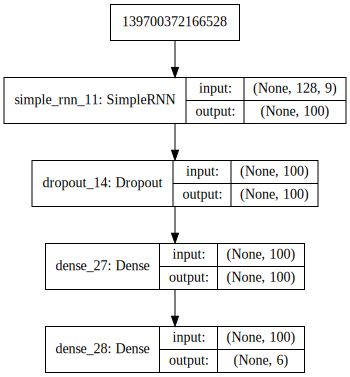

In [11]:
SVG(model_to_dot(rnn,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [0]:
lstm = load_model('/content/drive/My Drive/Colab Notebooks/LAR/LSTM.hdf5')

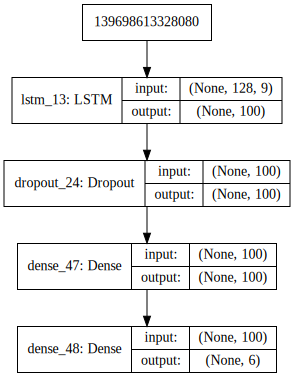

In [13]:
SVG(model_to_dot(lstm,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))